# Robust barcode decoder

_Francisco Gonzalez_

**Goal:** Decode a set of barcodes from images that may have been taken without autofocus

**Approach Overview**: The general approach for this project is to apply a series of image processing techniques if the barcode is not decoded from the image directly. This will involve effectively localizing and extracting the barcode from the image and optionally applying some thresholding techniques to sharpen the non-autofocus barcodes.

**Key challenges**: There are a couple of key challenges when decoding non-autofocus barcode images. The first challenge is in localization and extracting the barcodes. This is because the algorithm to localize and extract the barcodes involves a series of edge enhacement, thresholding, and shape analysis that all have sets of hyperparameters that may not be optimal. Without further tuning, barcodes may not be localized correctly or fully extracted. The second key challenge is in preprocessing extracted barcodes from non-autofocus images. The approach taken here is to apply adaptive Gaussian thresholding to sharpen the barcodes, but this assumes that the barcode was extracted correctly and that it is not hopelessly blurry. Again, without further tuning it is possible that the extracted and processed barcode cannot be decoded.

In [1]:
import os
import sys
import glob

import cv2

import zbar

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

## 0. Extract Data

Download barcode dataset. This should contain two labeled datasets:
    1. Dataset1 - Images of barcodes taken from devices with autofocus
    2. Dataset2 - Images of barcodes taken from devices without autofocus

Run the following two cells only once

In [ ]:
! wget http://artelab.dista.uninsubria.it/downloads/datasets/barcode/medium_barcode_1d/medium_barcode_1d.zip

In [ ]:
! unzip medium_barcode_1d.zip

At this point we can gather the paths and labels for each dataset into a list of tuples with the format `(image path, label)`, e.g.,
    
    [('BarcodeDatasets/Dataset1/05102009209.jpg', '8002330051617'),
     ('BarcodeDatasets/Dataset1/05102009157.jpg', '8004020931773'),
     ...]

In [2]:
def read_label(p):
    with open(p, "r") as f:
        label = f.read()
    return label

In [3]:
# Dataset 1: Autofocus barcode image and label paths
af_images = glob.glob("BarcodeDatasets/Dataset1/*.jpg")
af_labels = [read_label(p+".txt") for p in af_images]
af_dataset = [(img,label) for img, label in zip(af_images, af_labels)]

# Dataset 2: Non-autofocus barcode image and label paths
naf_images = glob.glob("BarcodeDatasets/Dataset2/*.jpg")
naf_labels = [read_label(p+".txt") for p in naf_images]
naf_dataset = [(img,label) for img, label in zip(naf_images, naf_labels)]

Read and show an example barcode image with its corresponding decoded label

In [4]:
def show_barcode_and_labels(img_path, label=None, pred=None, bbox=None):
    # Read image and covert to BGR colorspace
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Plot image along with decoded barcode
    if bbox is not None:
        cv2.drawContours(img, [bbox], -1, (0, 255, 0), 3)
    fig, ax = plt.subplots(1,1)
    ax.imshow(img)
    if label is not None:
        ax.text(50,100,f"True: {label}",bbox=dict(facecolor=(0.1,0.8,0.1),alpha=0.7),fontsize=14,color="white")
    if pred is not None:
        ax.text(50,250,f"Pred: {pred}",bbox=dict(facecolor=(0.1,0.1,0.8),alpha=0.7),fontsize=14,color="white")
            

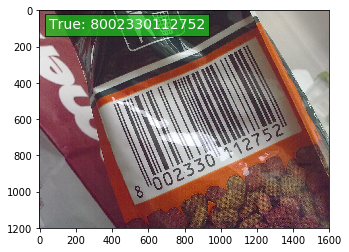

In [5]:
# Autofocus barcode
i = np.random.randint(0,len(af_dataset))
show_barcode_and_labels(af_dataset[i][0], af_dataset[i][1])

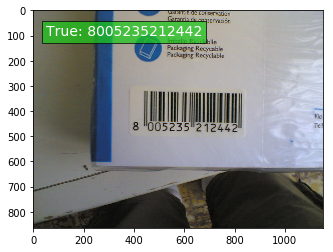

In [6]:
# Non-autofocus barcode
i = np.random.randint(0,len(naf_dataset))
show_barcode_and_labels(naf_dataset[i][0], naf_dataset[i][1])

## 1. Localize and extract barcodes from images

The goal is to extract the barcodes from the images by localizing and cropping the barcode using a bounding box. This will make it much easier to decode the barcode and preprocess if it is blurry.

Since there is very little data (and none with ground truth bounding boxes) this will require traditional computer vision methods rather than a deep learning approach.

Luckily, this is a classic problem with many approaches mostly around finding the contour that corresponds to the barcode.

In [7]:
def find_barcode(img):
    """Localizes and crops the barcode from the image
    
    Args:
        img: ndarray of size [l,w,3] in RGB colorspace
        
    Returns:
        barcode_img: ndarray of size [b_l, b_w] in gray colorspace
        bbox: list of 4 coordinates of the barcode
    """
    ## First, localize the barcode within the image
    
    # Convert image to gray
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Equalize lighting
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    
    # Enhance edges
    edge = cv2.Laplacian(img, ddepth=cv2.CV_8U, ksize=3, scale=1, delta=0)
    
    # Bilateral blur
    blurred = cv2.bilateralFilter(edge, 13, 50, 50)
    
    # Threshold
    _, th = cv2.threshold(blurred, 55, 255, cv2.THRESH_BINARY)
    
    # Isolate barcode through series of erosions and dilations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21,7))
    closing = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)
    erosion = cv2.erode(closing, None, iterations=4)
    dilation = cv2.dilate(erosion, None, iterations=4)
    
    # Find contours - the barcode should be the largest
    cnts, _ = cv2.findContours(
        dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    rect = cv2.minAreaRect(c)
    bbox = np.int0(cv2.boxPoints(rect))
    
    ## At this point we want to extract the barcode from the image

    # Get center, size, and theta of the barcode rectangle
    center, size, theta = rect
    
    # Convert to int
    center, size = tuple(map(int, center)), tuple(map(int, size))
    
    # Get rotation matrix for the rectangle
    M = cv2.getRotationMatrix2D(center, theta, 1)
    
    # Perform rotation and extract barcode
    dst = cv2.warpAffine(img, M, img.shape[:2])
    barcode_img = cv2.getRectSubPix(dst, size, center)

    return barcode_img, bbox

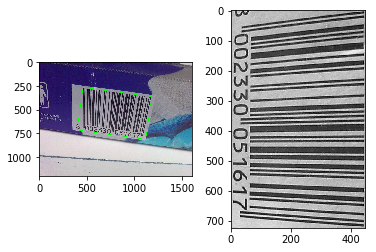

In [8]:
# Example extracted autofocus barcode
af_img = cv2.imread(af_dataset[-1][0])
af_barcode, bbox = find_barcode(af_img)
fig, ax = plt.subplots(1,2)
cv2.drawContours(af_img, [bbox], -1, (0, 255, 0), 3)
ax[0].imshow(af_img)
ax[1].imshow(af_barcode, cmap="gray")

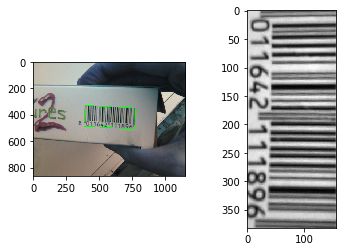

In [9]:
# Example extracted non-autofocus barcode
naf_img = cv2.imread(naf_dataset[-1][0])
naf_barcode, bbox = find_barcode(naf_img)
fig, ax = plt.subplots(1,2)
cv2.drawContours(naf_img, [bbox], -1, (0, 255, 0), 3)
ax[0].imshow(naf_img)
ax[1].imshow(naf_barcode, cmap="gray")

## 1.5. (Optionally) Process extracted barcode

An additional step that would increase the robustness of decoding barcodes from a non-autofocus image is to further preprocess the extracted barcode by sharpening the image. This, of course, assumes that the extraction portion works almost perfectly.

One simple approach is to apply adaptive thresholding to sharpen the image. Here adaptive Gaussian thresholding is applied.

In [10]:
def sharpen_barcode(barcode):
    th = cv2.adaptiveThreshold(
        barcode, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return th

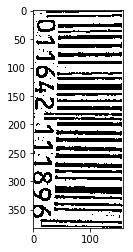

In [11]:
th_barcode = sharpen_barcode(naf_barcode)
plt.imshow(th_barcode, cmap="gray")

The downfall of this approach is that it a) assumes that the barcode was perfectly extracted, otherwise thresholding may be corrupted by surrounding features, and b) even if the barcode was extracted perfectly it may need specific tuning based on how blurry the barcode is. In short, it is not a one-size-fits-all solution.

## 2. Decode barcode

At this point we can write a method that takes in an image path and attempts to decode the barcode. In this case, it will take the following steps:

1. Attempt to decode the barcode from the image directly
2. If no barcode is detected, it will extract the barcode directly from the image.
3. Attempt to decode the extracted barcode
4. If no barcode is detected again, apply further thresholding to the extracted barcode. This is risky since at this point there are no guarantees that the barcode is perfectly extracted or that is not hopelessly blurry.

In [12]:
# Some helper functions
def _decode_barcode(img):
    """Use zbar to decode barcode"""
    # Create scanner
    scanner = zbar.Scanner()
    # Scan image
    results = scanner.scan(img)
    # No barcode detected
    if len(results)==0:
        return "no barcode detected"
    # Return barcode with highest quality score
    barcode = results[-1].data
    return barcode

In [13]:
def decode_barcode(img_path, label=None):
    """Decode barcode from image. If no barcode is detected, use cropped
    barcode. This may help with non-autofocus images.
    
    Args:
        img_path: path to the image
        label: optional - true label of the barcode
    
    Returns:
        predicted label if one is found, and a the annotated image
    """
    # Read image and convert to grayscale
    img = cv2.imread(img_path)
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Attempt to decode barcode from image directly
    barcode = _decode_barcode(gimg)
    if barcode != "no barcode detected":
        # Show image with predicted label
        show_barcode_and_labels(img_path, label=label, pred=barcode, bbox=None)        
        return img, None, barcode
    else:
        print("No barcode detected!")
        print("Extracting barcode from image")
        barcode_img, bbox = find_barcode(img)
    
    # Attempt to decode extracted barcode
    barcode = _decode_barcode(barcode_img)
    if barcode != "no barcode detected":
        # Show image with predicted label and bounding box
        show_barcode_and_labels(img_path, label=label, pred=barcode, bbox=bbox)        
        return img, barcode_img, barcode
    else:
        print("No barcode detected again!")
        print("Processing extracted barcode")
        barcode_img = sharpen_barcode(barcode_img)
    
    # Final attempt
    barcode = _decode_barcode(barcode_img)
    if barcode != "no barcode detected":
        # Show image with predicted label and bounding box
        show_barcode_and_labels(img_path, label=label, pred=barcode, bbox=bbox)
        return img, barcode_img, barcode
    else:
        print("No barcode detected, sorry!")
        # Show image with extracted bounding box
        show_barcode_and_labels(img_path, label=label, pred=barcode, bbox=bbox)
        return None, None, None

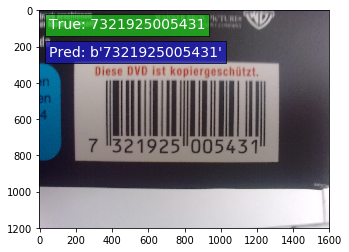

In [14]:
# Example 1: Autofocus
i = np.random.randint(0,len(af_dataset))
img, barcode_img, barcode = decode_barcode(
    af_dataset[i][0], af_dataset[i][1]
)

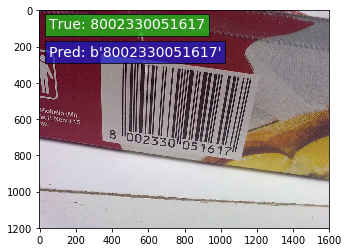

In [16]:
# Example 2: Autofocus
i = np.random.randint(0,len(af_dataset))
img, barcode_img, barcode = decode_barcode(
    af_dataset[i][0], af_dataset[i][1]
)

No barcode detected!
Extracting barcode from image


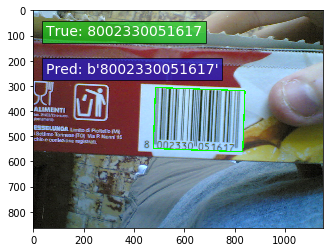

In [17]:
# Example 4: Non-autofocus
i = np.random.randint(0,len(naf_dataset))
img, barcode_img, barcode = decode_barcode(
    naf_dataset[i][0], naf_dataset[i][1]
)

No barcode detected!
Extracting barcode from image


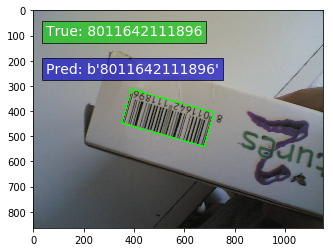

In [18]:
# Example 4: Non-autofocus
i = np.random.randint(0,len(naf_dataset))
img, barcode_img, barcode = decode_barcode(
    naf_dataset[i][0], naf_dataset[i][1]
)